In [1]:
%matplotlib inline
import numpy as np
import pprint as pp
import random
from datetime import datetime
from itertools import combinations
import string
import pandas
from collections import Counter

Reading in the secret message

In [2]:
with open ("encyrption.txt", "r") as myfile:
    message=myfile.read().replace('\n', '')

pairFreq = np.loadtxt('pairFreq.dat')

pp.pprint(message)

'BIU V DICT ZMEF VBZFU MZ NVJ OJGFUFL MCZI ZGMJ NIUDL IB JIUUIN VCL ZUIOQDF QK ZGF HVUMJG JOUTFIC MZ UFEVMCFL V EVZZFU IB PICJMLFUVQDF LIOQZ NGFZGFU ZGF PGMDL NIODL JOURMRF ZI QFVU VCK CVEF VZ VDD MC NGMPG PVJF MZ MJ JIEFNGVZ EIUF ZGVC HUIQVQDF ZGVZ ZGFJF EFEIMUJ NIODL CFRFU GVRF VHHFVUFL IU MB ZGFK GVL ZGVZ QFMCT PIEHUMJFL NMZGMC V PIOHDF IB HVTFJ ZGFK NIODL GVRF HIJJFJJFL ZGF MCFJZMEVQDF EFUMZ IB QFMCT ZGF EIJZ PICPMJF VCL BVMZGBOD JHFPMEFC IB QMITUVHGK FYZVCZ MC ZGF DMZFUVZOUF IB VCK VTF IU PIOCZUK '


In [3]:
pairFreq = np.loadtxt('pairFreq.dat')
pairFreq.shape

(27, 27)

## Useful Functions:

In [4]:
def get_map():
    alphabet = string.uppercase
    key = ''.join(random.sample(alphabet,len(alphabet)))
    myMap = dict(zip(alphabet, key))
    myMap[' '] = ' '
    return myMap

def key_swap(myMap, swap_pick):
    swapMap = dict(myMap)
    swapMap[swap_pick[0]] = myMap[swap_pick[1]]
    swapMap[swap_pick[1]] = myMap[swap_pick[0]]
    return swapMap

def rate_string(M, s):
    lookup = string.uppercase + ' '
    return np.sum(M[lookup.find(s[i])][lookup.find(s[i+1])] for i in range(len(s) - 1))

def encrypt(s, myMap):
    return ''.join([myMap[c] for c in list(s)])

def MC_decrypt():
    pass

In [5]:
myMap = get_map()
print "My initial random guess"
pp.pprint(myMap)

My initial random guess
{' ': ' ',
 'A': 'C',
 'B': 'S',
 'C': 'R',
 'D': 'F',
 'E': 'A',
 'F': 'L',
 'G': 'O',
 'H': 'J',
 'I': 'G',
 'J': 'Z',
 'K': 'T',
 'L': 'M',
 'M': 'U',
 'N': 'I',
 'O': 'H',
 'P': 'W',
 'Q': 'Q',
 'R': 'V',
 'S': 'N',
 'T': 'D',
 'U': 'X',
 'V': 'P',
 'W': 'B',
 'X': 'E',
 'Y': 'K',
 'Z': 'Y'}


In [17]:
nsteps = 1000
allSwaps = [''.join(i) for i in combinations(string.uppercase, 2)]

oldS = message
p = rate_string(pairFreq, oldS)
newp = 0.0
oldmap = dict(myMap)

t = 0
t0 = datetime.now()
for i in range(nsteps):
    mySwap = allSwaps[random.randint(0,len(allSwaps)-1)]
    newmap = dict(key_swap(oldmap, mySwap))
    newS = encrypt(oldS, newmap)
    newp = rate_string(pairFreq, newS)
    if(p < newp):
        oldmap = dict(newmap)
        p = newp
        #oldS = newS
        t += 1
        
t1 = datetime.now()
tdiff = t1-t0

print "Total run time: " + str(tdiff)[2:10] + "s"
print "p = " + str(p)
print "Acceptance Ratio = " + str(100*float(t)/float(nsteps)) + '%'
print encrypt(oldS, oldmap)

Total run time: 00:00.73s
p = 41034258.0
Acceptance Ratio = 6.9%
FOR A LONG TIBE AFTER IT WAS USHERED INTO THIS WORLD OF SORROW AND TROUMLE MY THE PARISH SURGEON IT REBAINED A BATTER OF CONSIDERAMLE DOUMT WHETHER THE CHILD WOULD SURVIVE TO MEAR ANY NABE AT ALL IN WHICH CASE IT IS SOBEWHAT BORE THAN PROMAMLE THAT THESE BEBOIRS WOULD NEVER HAVE APPEARED OR IF THEY HAD THAT MEING COBPRISED WITHIN A COUPLE OF PAGES THEY WOULD HAVE POSSESSED THE INESTIBAMLE BERIT OF MEING THE BOST CONCISE AND FAITHFUL SPECIBEN OF MIOGRAPHY EKTANT IN THE LITERATURE OF ANY AGE OR COUNTRY 


## Other Stuff

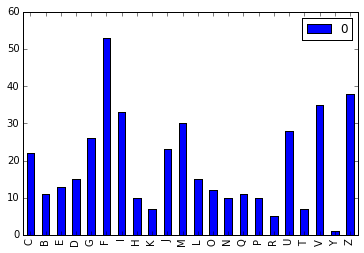

In [16]:
nospaces = ''.join([x for x in message.split()])
letter_counts = Counter(sorted(nospaces))
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')